# Work at Olist

In this notebook we are going to study the [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce#olist_public_dataset_v2_payments.csv) and make a sentiment analysis of the reviews of several purchases at **Olist**.

**First** we need to import the libraries and setup our environment.

In [1]:
import io

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import requests
import rows
from sklearn import feature_extraction, preprocessing, model_selection, linear_model, metrics
import unidecode

nltk.download(['stopwords', 'punkt'])
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/john/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/john/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Then we're going to load the datasets. We will be using the classified dataset and try to enrchich the data prior to modeling.

In [2]:
df_pub = pd.read_csv("olist_public_dataset_v2.csv")
df_clas = pd.read_csv("olist_classified_public_dataset.csv", index_col=0)
df_cus = pd.read_csv("olist_public_dataset_v2_customers.csv")
df_pay = pd.read_csv("olist_public_dataset_v2_payments.csv")
df_clas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3584 entries, 0 to 3583
Data columns (total 33 columns):
id                               3584 non-null int64
order_status                     3584 non-null object
order_products_value             3584 non-null float64
order_freight_value              3584 non-null float64
order_items_qty                  3584 non-null int64
order_sellers_qty                3584 non-null int64
order_purchase_timestamp         3584 non-null object
order_aproved_at                 3584 non-null object
order_estimated_delivery_date    3584 non-null object
order_delivered_customer_date    3467 non-null object
customer_city                    3584 non-null object
customer_state                   3584 non-null object
customer_zip_code_prefix         3584 non-null int64
product_category_name            3584 non-null object
product_name_lenght              3584 non-null int64
product_description_lenght       3584 non-null int64
product_photos_qty               

### 1. JOIN TABLES

We're starting by merging data from the avaliable tables. We want more information about the customer and the payment method.
The **common** columns for both dataframes are:

In [3]:
common_columns = [column for column in df_clas.columns if column in df_pub.columns and df_clas[column].dtype == df_pub[column].dtype]
common_columns

['order_status',
 'order_products_value',
 'order_freight_value',
 'order_items_qty',
 'order_sellers_qty',
 'order_purchase_timestamp',
 'order_aproved_at',
 'order_estimated_delivery_date',
 'order_delivered_customer_date',
 'customer_city',
 'customer_state',
 'customer_zip_code_prefix',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'review_score',
 'review_comment_message',
 'review_creation_date',
 'review_answer_timestamp']

In [4]:
[column for column in df_clas.columns if column in df_pub.columns and df_clas[column].dtype != df_pub[column].dtype]

['review_comment_title']

It's interesting to see that `review_comment_title` has a different data type in each table. By looking at the information on the columns we see that all values are `null`, so we're dropping this column.

In [5]:
df_clas = df_clas.drop(columns="review_comment_title")
df_pub = df_pub.drop(columns="review_comment_title")

The columns that are present **only** in `olist_public_dataset_v2` are:

In [6]:
[column for column in df_clas.columns if column not in df_pub.columns]

['id',
 'votes_before_estimate',
 'votes_delayed',
 'votes_low_quality',
 'votes_return',
 'votes_not_as_anounced',
 'votes_partial_delivery',
 'votes_other_delivery',
 'votes_other_order',
 'votes_satisfied',
 'most_voted_subclass',
 'most_voted_class']

And the columns that are present **only** in `olist_classified_public_dataset` are:

In [7]:
new_columns = [column for column in df_pub.columns if column not in df_clas.columns]
new_columns

['order_id', 'customer_id', 'product_id', 'review_id']

This means that with some luck we can gather customer and product data from the other tables. We've found **22** duplicated rows in the `olist_classified_public_dataset` according to the common columns. We're going to discard this data since we don't know why these lines are repeated.

In [8]:
df = df_clas[~df_clas[common_columns].duplicated(keep=False)]
df = df.merge(df_pub, on=common_columns, how="inner", validate="1:m")
df_pub = df_pub.merge(df_cus, on='customer_id')
df.shape

(2812, 36)

As we can see we managed to join **2812** data points, around 80%. We'll work with this data from now on.

In [9]:
df = df.merge(df_cus, how="inner", on="customer_id", validate="m:m")
df.shape

(2812, 37)

We successfully joined both tables and now it's possible to characterize each user in the dataset. Next we will join the payments table. 

We have found some duplicated data in the `olist_public_dataset_v2_payments` table, so we will discard them. Then, since each order might have several payments, first we need to group this data.

In [10]:
df_pay = df_pay.drop_duplicates()

Although we dropped the duplicated values, there's also some rows in which the sequential is not correct, as shown in the table below:

In [11]:
df_ord = df_pay.groupby('order_id').size() != df_pay.groupby('order_id')['sequential'].max()
df_pay_seq = df_pay[df_pay['order_id'].isin(df_ord[df_ord].index)].sort_values('order_id')
print("# Orders with wrong sequential: {0}".format(len(df_pay_seq)))
df_pay_seq.head()

# Orders with wrong sequential: 75


,order_id,installments,sequential,payment_type,value
103503,0a7d898c6305101e69e9f5a05cd0130d,5,2,credit_card,215.47
79097,0d0e88a418636d40ea780339701db49c,1,2,debit_card,121.09
87767,1896e8b8fd196151559b02e31e98ce89,1,2,debit_card,108.95
17017,19404a71ed27e962d66a7f6cf9022722,1,2,debit_card,44.30
100149,1a57108394169c0b47d8f876acc9ba2d,0,2,credit_card,129.94


We're going to ignore the sequential in this analysis and try to create some features that can be used for training. We will use the *mean* of the `installments`, the quantity of splits, the most common `payment_type`, and the *standard deviation* of the `value`.

In [12]:
def most_frequent_category(row):
    '''Calculates the most frequent value in 'row'. 
    If there's more than one value, the values will be sorted and separated by comma'''
    counts = row.value_counts()
    return ','.join(counts[counts == counts.max()].sort_values().index)

df_pay = df_pay.groupby(['order_id']).agg(
    {'installments': 'mean', 
     'sequential': 'count', 
     'payment_type': most_frequent_category, 
     'value': 'std'}).fillna(0)
df_pay = df_pay.rename(columns={'sequential': 'seq_count', 'payment_type': 'preffered_payment', 'value': 'value_std'})

In [13]:
df = df.merge(df_pay, left_on='order_id', right_index=True, validate="m:1")
df.shape

(2812, 41)

So, our final table has *2812* rows and *41* columns from 4 tables of the dataset.

### 2. Enriching Data

Now We're going to add more features to the table, more specifically we will gather geographical information to our dataset. This is done by extracting data from [Lista de municípios do Brasil por população](https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_popula%C3%A7%C3%A3o) and [Lista de municípios brasileiros por área decrescente](https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_brasileiros_por_%C3%A1rea_decrescente) from wikipedia.

In [14]:
# Population data
req_pop = requests.get("https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_popula%C3%A7%C3%A3o")
bs_pop = BeautifulSoup(req_pop.text)
table_pop = rows.import_from_html(io.BytesIO(str(bs_pop.find('table')).encode('utf-8')), encoding='utf-8', preserve_html=True)
df_pop = pd.DataFrame(rows.export_to_dicts(table_pop))
table_sigla = """ESTADO,SIGLA
Acre,AC
Alagoas,AL
Amapá,AP
Amazonas,AM
Bahia,BA
Ceará,CE
Distrito Federal,DF
Espírito Santo,ES
Goiás,GO
Maranhão,MA
Mato Grosso,MT
Mato Grosso do Sul,MS
Minas Gerais,MG
Pará,PA
Paraíba,PB
Paraná,PR
Pernambuco,PE
Piauí,PI
Rio de Janeiro,RJ
Rio Grande do Norte,RN
Rio Grande do Sul,RS
Rondônia,RO
Roraima,RR
Santa Catarina,SC
São Paulo,SP
Sergipe,SE
Tocantins,TO"""
df_sigla = pd.read_csv(io.StringIO(table_sigla))

df_pop['municipio'] = df_pop['municipio'].str.replace('<[^>]*>', '').str.strip().str.upper().apply(unidecode.unidecode).str.replace('[^\w\d\s]', '')
df_pop['unidade_federativa'] = df_pop['unidade_federativa'].str.replace('<[^>]*>', '').str.strip()
df_pop['posicao'] = df_pop['posicao'].str.replace('º', '').astype(int)
df_pop = df_pop.merge(df_sigla, left_on='unidade_federativa', right_on='ESTADO')
df_pop = df_pop.drop(columns=['ESTADO', 'posicao']).rename(columns={'SIGLA': 'sigla'})

In [15]:
# Area data
req_area = requests.get('https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_brasileiros_por_%C3%A1rea_decrescente')
bs_area = BeautifulSoup(req_area.text)
for tag in bs_area.findAll('a'):
    tag.replaceWithChildren()
for tag in bs_area.findAll('img'):
    tag.decompose()
table_area = rows.import_from_html(io.BytesIO(str(bs_area.find('table')).encode('utf-8')), encoding='utf-8', preserve_html=True)
df_area = pd.DataFrame(rows.export_to_dicts(table_area))
df_area['area_km2'] = df_area['area_km2'].str.replace('<[^>]*>', '').str.strip().str.replace('[,\s]', '').astype(int)
df_area = df_area.drop(columns=['municipio', 'posicao', 'unidade_federativa']).rename(columns={'codigo_do_ibge': 'codigo_ibge'})
# Merge tables
df_pop = df_pop.merge(df_area, on='codigo_ibge', how='outer')
df_pop['density'] = df_pop['populacao']/df_pop['area_km2']
df_pop.head()

,codigo_ibge,municipio,populacao,unidade_federativa,sigla,area_km2,density
0,3550308,SAO PAULO,12106920,São Paulo,SP,1522986.0,7.949462
1,3518800,GUARULHOS,1349113,São Paulo,SP,318014.0,4.242307
2,3509502,CAMPINAS,1182429,São Paulo,SP,795697.0,1.486029
3,3548708,SAO BERNARDO DO CAMPO,827437,São Paulo,SP,406180.0,2.037119
4,3547809,SANTO ANDRE,715231,São Paulo,SP,174840.0,4.090774


In [16]:
# Merge to the dataset
df['customer_city'] = df['customer_city'].str.upper().apply(unidecode.unidecode).str.replace('[^\w\d\s]', '')
df = df.merge(df_pop, left_on=['customer_city', 'customer_state'], right_on=['municipio', 'sigla'], how='left')
df.shape

(2812, 48)

And so we have a table with some geographical data. The important columns that we added are `populacao` which is the *population* of the city, then the city *area* in the column `area_km2`, the populational `density`, and we also have a column named `codigo_ibge` that is an internal code for each city. With this code we could query the [IBGE API](https://servicodados.ibge.gov.br/api/docs) to further enrich the dadta.

### 3. Feature Selection and Engineering

Based on this table we can select and tweak the data that is important to us. 

In [17]:
# Setting up date columns
date_columns = [
    'order_purchase_timestamp',
    'order_aproved_at',
    'order_estimated_delivery_date',
    'order_delivered_customer_date',
    'review_creation_date',
    'review_answer_timestamp'
]
for date_col in date_columns:
    df[date_col] = pd.to_datetime(df[date_col])

In [18]:
# Dropping columns
drop_columns = [
    'id',
    'order_id', 
    'customer_id', 
    'product_id', 
    'review_id', 
    'codigo_ibge', 
    'unidade_federativa', 
    'sigla', 
    'municipio',
    'most_voted_subclass',
    'most_voted_class',
    'customer_zip_code_prefix'
]
df = df.drop(columns=drop_columns)

In [19]:
# Encoding categorical data
df_feat = df.copy()
one_hot_columns = [
    'order_status',
    'product_category_name',
    'customer_city',
    'customer_state',
    'preffered_payment'
]
df_feat = pd.concat([df_feat, pd.get_dummies(df_feat[one_hot_columns])], sort=False, axis=1).drop(columns=one_hot_columns)

In [20]:
# Filling empty geographical data
df_feat['populacao'] = df_feat['populacao'].fillna(df_pop['populacao'].mean().astype(int))
df_feat['area_km2'] = df_feat['area_km2'].fillna(df_pop['area_km2'].mean().astype(int))
df_feat['density'] = df_feat['density'].fillna(df_feat['density'].mean())

In [21]:
# Creating date features (in days)
df_feat['purchase_approved'] = (df_feat['order_aproved_at'] - df_feat['order_purchase_timestamp']).dt.days
df_feat['purchase_delivered'] = (df_feat['order_delivered_customer_date'] - df_feat['order_purchase_timestamp']).dt.days
df_feat['purchase_estimated'] = (df_feat['order_estimated_delivery_date'] - df_feat['order_purchase_timestamp']).dt.days
df_feat['approved_estimated'] = (df_feat['order_estimated_delivery_date'] - df_feat['order_aproved_at']).dt.days
df_feat['approved_delivered'] = (df_feat['order_delivered_customer_date'] - df_feat['order_aproved_at']).dt.days
df_feat['estimated_delivered'] = (df_feat['order_delivered_customer_date'] - df_feat['order_estimated_delivery_date']).dt.days
df_feat['review_answer'] = (df_feat['review_answer_timestamp'] - df_feat['review_creation_date']).dt.days
df_feat['purchase_review'] = (df_feat['review_creation_date'] - df_feat['order_purchase_timestamp']).dt.days
drop_columns = [
    'order_aproved_at',
    'order_purchase_timestamp',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'review_creation_date',
    'review_answer_timestamp'
]
df_feat = df_feat.drop(columns=drop_columns)

In [22]:
# Creating user features
def process_customer_text(rows):
    words = [token for token in nltk.word_tokenize(' '.join(rows.fillna(''))) 
             if token not in nltk.corpus.stopwords.words('portuguese')]
    words_set = set(words)
    return {
        'review_count': len(rows),
        'mean_unique_tokens': len(words_set)/len(rows), 
        'mean_token_length': sum(map(len, words))/(len(words) or 1),
        'mean_repeated_words': (len(words)-len(words_set))/len(rows)}

df_customer_text = pd.DataFrame(df_pub[['customer_unique_id', 'review_comment_message']].groupby('customer_unique_id')['review_comment_message'].apply(process_customer_text))
df_customer_text = df_customer_text.unstack()
df_customer_text.columns = df_customer_text.columns.droplevel()
df_feat = df_feat.merge(df_customer_text, on='customer_unique_id').drop(columns='customer_unique_id')
df_feat['review_comment_message'] = df_feat['review_comment_message'].apply(unidecode.unidecode).str.replace('[^\w\d\s]', '')

In [23]:
# Creating review features - Filtering to the 500 most relevant words according to TF-IDF
MAX_FEATURES = 500
vectorizer = feature_extraction.text.TfidfVectorizer(
    stop_words=nltk.corpus.stopwords.words('portuguese'),
    max_features=MAX_FEATURES
)
vectorizer.fit(df_pub['review_comment_message'].fillna(''))
words = vectorizer.get_feature_names()

df_feat = pd.concat([df_feat, pd.DataFrame(columns=words)], axis=1)
df_feat[words] = 0
df_feat[words] = vectorizer.transform(df_feat['review_comment_message']).toarray()
df_feat = df_feat.drop(columns='review_comment_message')

In [24]:
# Normalizing features
df_feat['approved_delivered'] = df_feat['approved_delivered'].fillna(df_feat['approved_delivered'].median())
df_feat['purchase_delivered'] = df_feat['purchase_delivered'].fillna(df_feat['purchase_delivered'].median())
df_feat['estimated_delivered'] = df_feat['estimated_delivered'].fillna(df_feat['estimated_delivered'].median())
labels = [
    'votes_before_estimate',
    'votes_delayed',
    'votes_low_quality',
    'votes_return',
    'votes_not_as_anounced',
    'votes_partial_delivery',
    'votes_other_delivery',
    'votes_other_order',
    'votes_satisfied'
]

non_categorical_columns = ~df_feat.isin([0, 1]).all() & ~df_feat.columns.isin(words+labels)
non_categorical_columns = non_categorical_columns[non_categorical_columns].index
normalizer = preprocessing.Normalizer()
df_feat[non_categorical_columns] = normalizer.fit_transform(df_feat[non_categorical_columns])
df_feat.shape

(2812, 1420)

Finally, we created a dataframe with *2812* rows and *1419* columns. Of this columns 9 of them are *labels* and the rest are *features*.
### 4. Training Model
We intend to create a **logisic model** for this set of features, unfortunately we will suffer from the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). To address that we will use the first model to have insights of the most important features, then we can trim the features to have a better generic model. We also are going to use the votes to *boost* the model.

In [25]:
# Creating training and test sets
labels = [
    'votes_before_estimate',
    'votes_delayed',
    'votes_low_quality',
    'votes_return',
    'votes_not_as_anounced',
    'votes_partial_delivery',
    'votes_other_delivery',
    'votes_other_order',
    'votes_satisfied'
]
Y = df_feat[labels]
X = df_feat.drop(columns=labels)

def calculate_label(row, label_qt):
    max_votes = row.max()
    for label in label_qt.index:
        if row[label] == max_votes:
            return (label[6:], row[label])
y, weights = zip(*Y.apply(calculate_label, axis=1, args=(Y.sum(),)))

X_train, X_test, y_train, y_test, w_train, w_test = model_selection.train_test_split(X, y, weights, random_state=42)

In [26]:
model1 = linear_model.LogisticRegressionCV()
model1.fit(X_train, y_train, w_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

### 5. Model Evaluation

Model Accuracy Train: 97.2 %
Model Accuracy Test: 76.8 %
Confusion matrix:


,before_estimate,delayed,low_quality,return,not_as_anounced,partial_delivery,other_delivery,other_order,satisfied
before_estimate,80,4,3,1,0,0,1,0,16
delayed,1,62,0,0,7,1,6,1,11
low_quality,0,3,11,2,0,0,4,0,13
return,0,7,4,23,0,0,3,5,5
not_as_anounced,1,0,2,0,5,0,0,0,4
partial_delivery,0,2,0,0,0,2,0,0,1
other_delivery,0,9,0,1,0,0,58,1,1
other_order,0,6,1,2,1,0,1,10,1
satisfied,18,2,4,4,2,0,1,0,289


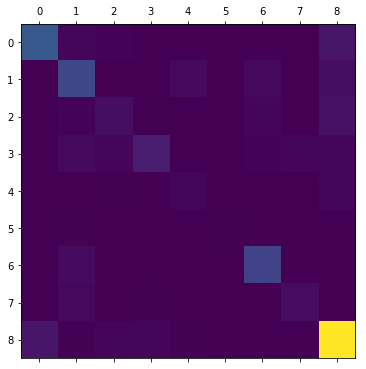

In [27]:
labels2 = [label[6:] for label in labels]
print("Model Accuracy Train:", (model1.score(X_train, y_train)*100).round(1), "%")
print("Model Accuracy Test:", (model1.score(X_test, y_test)*100).round(1), "%")
print("Confusion matrix:")
confusion = metrics.confusion_matrix(y_test, model1.predict(X_test))
plt.figure(figsize=(6,6))
plt.matshow(confusion, fignum=1)
pd.DataFrame(confusion, columns=labels2, index=labels2)

In [28]:
pd.concat([
    pd.DataFrame(model1.predict(X_test)).rename(columns={0: 'predicted'}), 
    pd.DataFrame(y_test).rename(columns={0: 'true'})], axis=1).head(20)

,predicted,true
0,low_quality,satisfied
1,satisfied,before_estimate
2,not_as_anounced,before_estimate
3,before_estimate,before_estimate
4,delayed,delayed
5,partial_delivery,partial_delivery
6,partial_delivery,partial_delivery
7,satisfied,satisfied
8,satisfied,satisfied
9,satisfied,satisfied


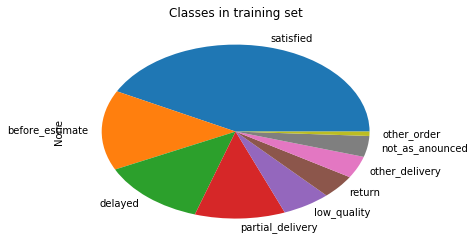

In [29]:
pd.Series(y_train).value_counts().plot.pie(title='Classes in training set')

The model `model1` we trained has *76.8%* accuracy for the test set, a majority class classifier would have around *42%*. By looking at the confusion matrix we see that the classes **before_estimate**, **delayed**, **other_delivery** and **satisfied** have better accuracy. Also, the model is overfitted which we will address later.

Let's evaluate the weights of the model to find insights about the data:

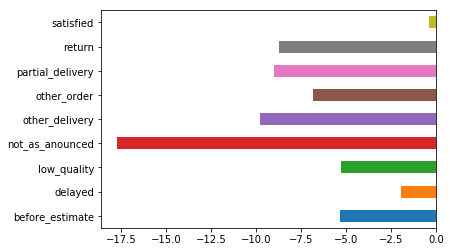

In [30]:
pd.Series(model1.intercept_, index=model1.classes_).plot.barh()

By looking at the *biases* we see that **satisfied** and **delayed** classes are more likely. While **not as anounced** is less likely and needs more positive weights to be chosen.

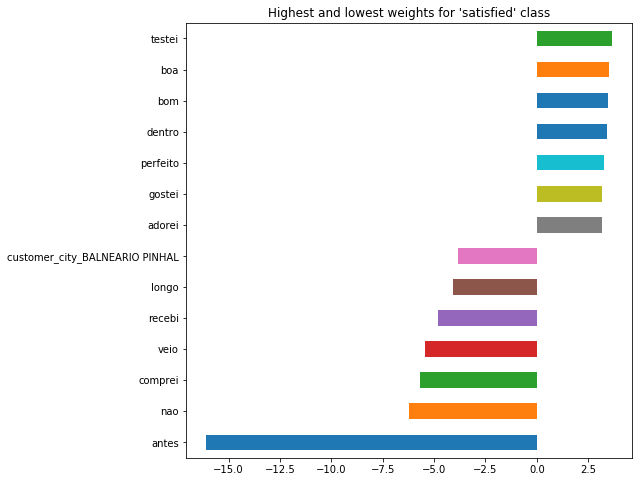

In [31]:
df_coef = pd.DataFrame(model1.coef_.T, columns=model1.classes_, index=X.columns)
NUMBER_OF_WEIGHTS = 7
def plot_weights(df_coef, cls, number):
    pd.concat([
        df_coef[cls].sort_values().head(number), 
        df_coef[cls].sort_values().tail(number)]
    ).plot.barh(figsize=(8,8), title="Highest and lowest weights for '{0}' class".format(cls))
plot_weights(df_coef, 'satisfied', NUMBER_OF_WEIGHTS)

As we can see, the weights of the model shows that some words are very likely to indicate that a review is positive. We can also see the other classes weights:

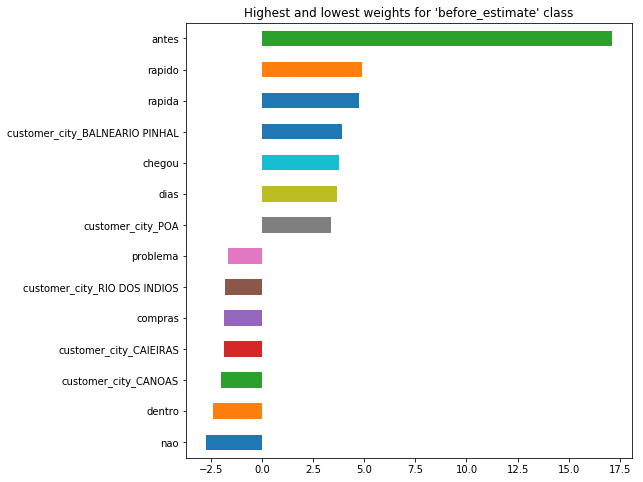

In [32]:
plot_weights(df_coef, 'before_estimate', NUMBER_OF_WEIGHTS)

It's interesting to see that the word **antes** is a very positive weight for **before_estimate** class and very negative for **satisfied**.

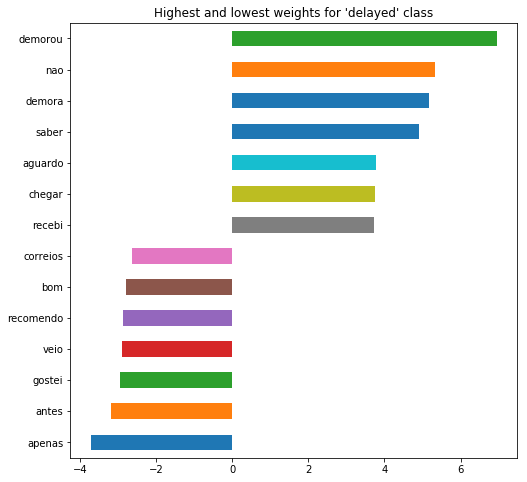

In [33]:
plot_weights(df_coef, 'delayed', NUMBER_OF_WEIGHTS)

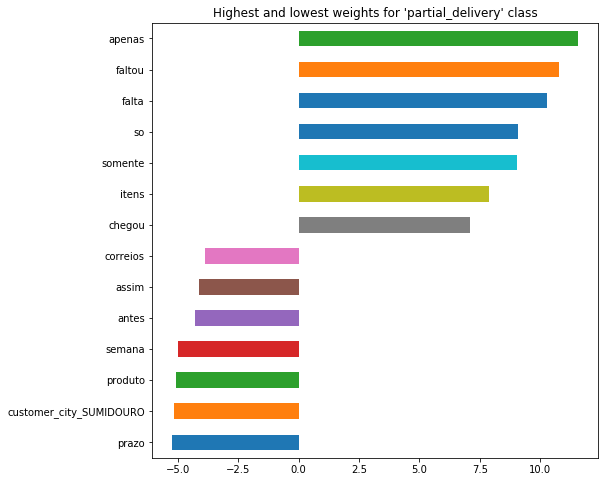

In [34]:
plot_weights(df_coef, 'partial_delivery', NUMBER_OF_WEIGHTS)

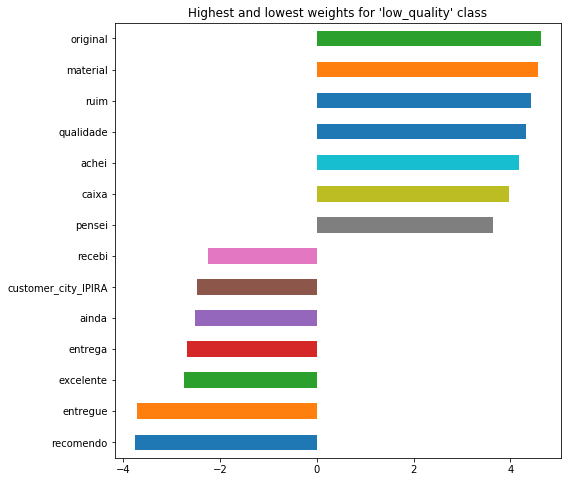

In [35]:
plot_weights(df_coef, 'low_quality', NUMBER_OF_WEIGHTS)

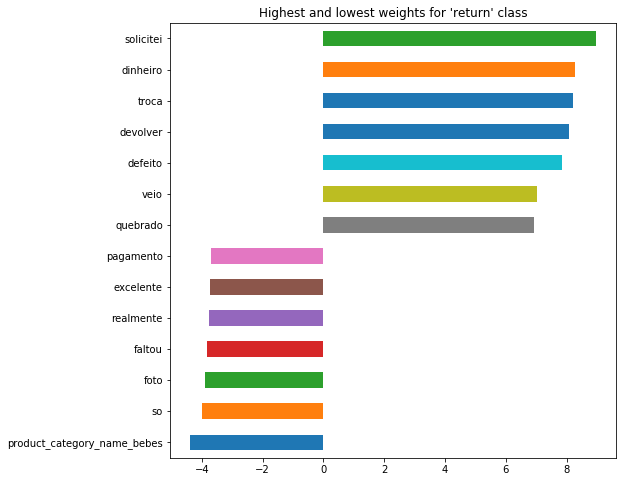

In [36]:
plot_weights(df_coef, 'return', NUMBER_OF_WEIGHTS)

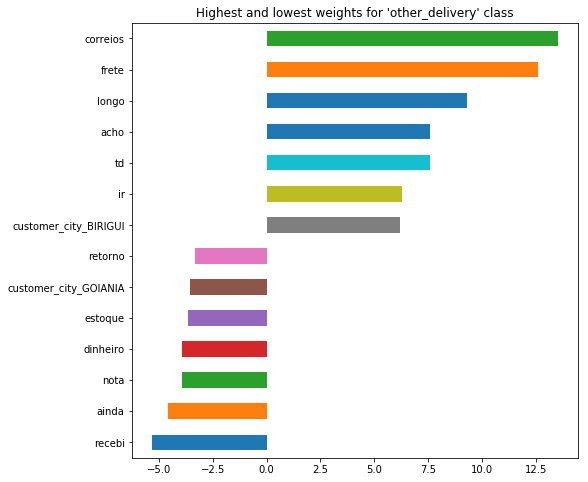

In [37]:
plot_weights(df_coef, 'other_delivery', NUMBER_OF_WEIGHTS)

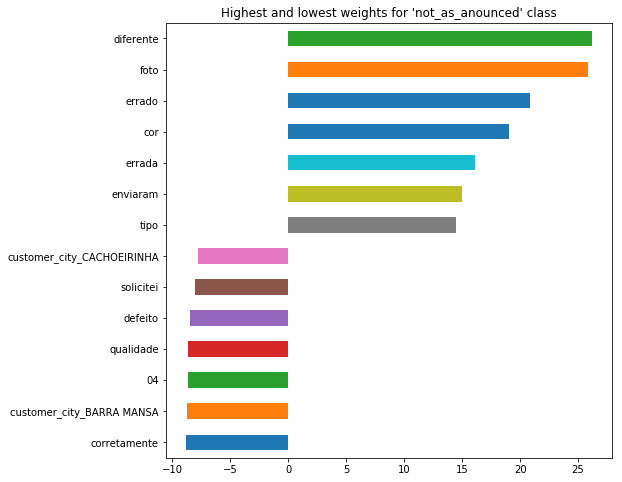

In [38]:
plot_weights(df_coef, 'not_as_anounced', NUMBER_OF_WEIGHTS)

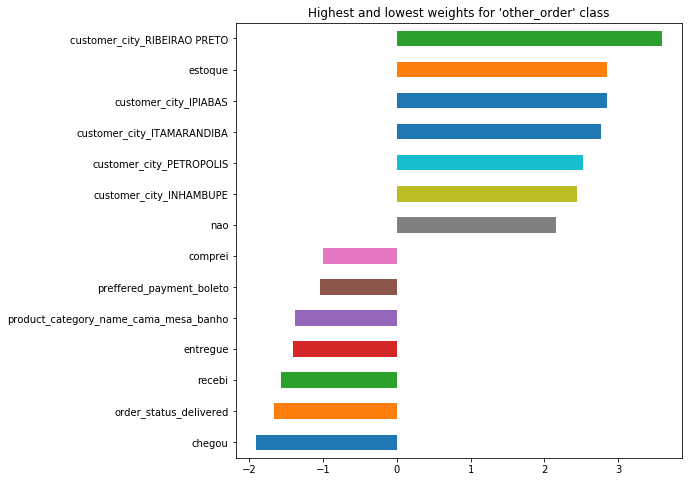

In [39]:
plot_weights(df_coef, 'other_order', NUMBER_OF_WEIGHTS)

We discovered a few things by looking at the class weights for each label of this model.
1. *Words* are usually the best features
2. There were 3 orders to *Balneario Pinhal* and all of them got delivered **before the estimate** biasing our weights. There are more cases of cities with few data points, indicating that these features are not good for this size of dataset.
3. For the **other_order** class we see some cities as indicators of this feature.

Now we will check each category of features:

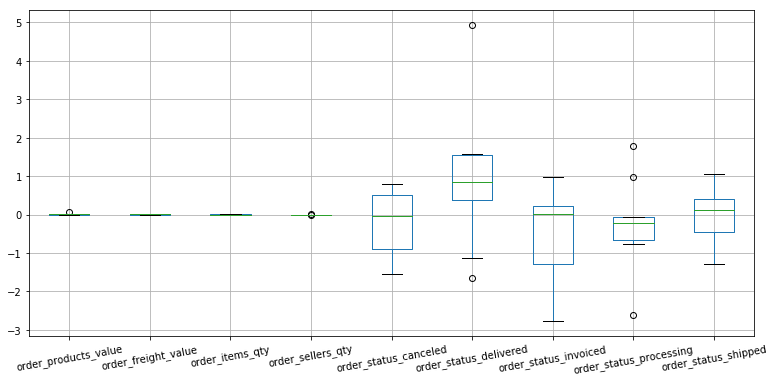

In [40]:
df_coef[df_coef.index.str.contains('order')].transpose().boxplot(figsize=(13, 6), rot=10)

By looking at the distributions of the features prefixed with *order*, we see that the `order_status` is an important feature for classifying the data, while the others are not.

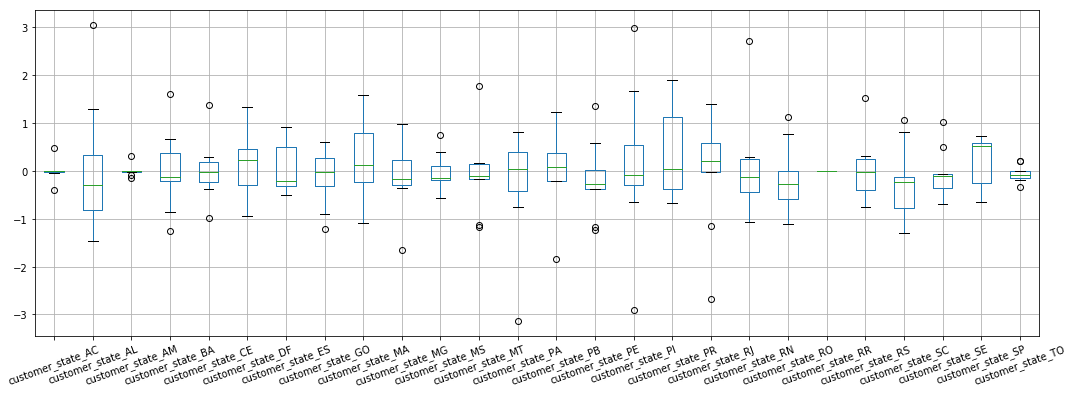

In [41]:
df_coef[df_coef.index.str.contains('customer_state')].transpose().boxplot(figsize=(18, 6), rot=20)

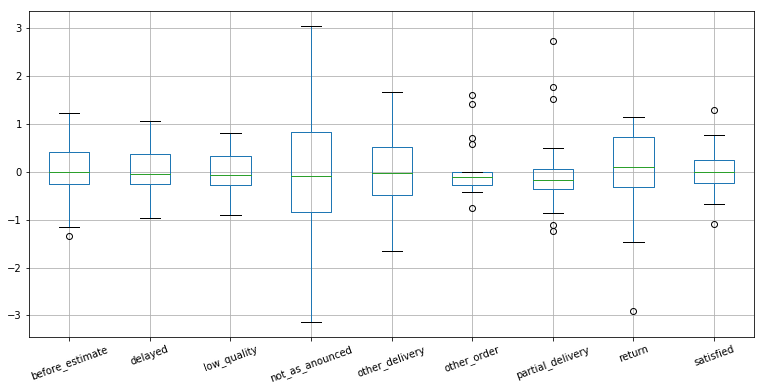

In [42]:
df_coef[df_coef.index.str.contains('customer_state')].boxplot(figsize=(13, 6), rot=20)

We see that the states features have a large distribuition of weights, in special for the **return** class and the *Mato Grosso* state, so we intend to keep them.

,before_estimate,delayed,low_quality,not_as_anounced,other_delivery,other_order,partial_delivery,return,satisfied
product_category_name_artes,-0.254287,-0.962696,1.311816,6.828507,-0.106985,-0.207179,-0.151295,-0.106531,-0.338102
product_category_name_bebes,0.543111,-0.024734,0.107017,0.940672,1.623455,-0.509440,1.240160,-4.378157,-0.201092
product_category_name_eletrodomesticos,0.658944,-0.863881,-1.189324,5.931906,-0.600916,-0.150163,1.731360,3.245128,-1.455523
product_category_name_relogios_presentes,0.076763,-0.107152,0.028978,-7.334142,-1.089634,0.417925,-1.954800,1.535657,0.460575


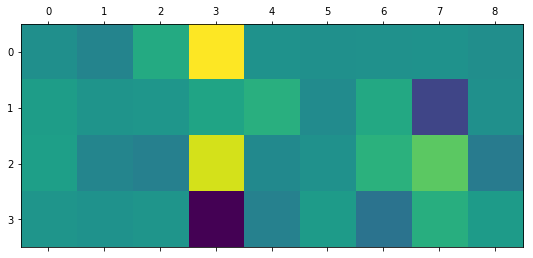

In [43]:
categories_features_regex = 'product_category_name_bebes|product_category_name_artes|product_category_name_eletrodomesticos$|product_category_name_relogios_presentes'
plt.matshow(df_coef[df_coef.index.str.contains(categories_features_regex)])
df_coef[df_coef.index.str.contains(categories_features_regex)]

For the features that starts with the prefix *product_*, we have found that their weights are considerable and the most relevant are *eletrodomesticos* and *artes* that are very likely to be of the **not as anounced** class, while *bebes* is likely not to belong to the **return** class, Nor *relogios and presentes* is likely to be **not as anounced**.

,before_estimate,delayed,low_quality,not_as_anounced,other_delivery,other_order,partial_delivery,return,satisfied
preffered_payment_boleto,-1.301412,-0.241780,0.033980,1.095535,0.473401,-1.039331,0.019754,0.045963,0.985079
preffered_payment_credit_card,-0.806465,-0.197652,-0.354865,0.373529,0.238216,1.584876,-0.552429,0.147116,0.790100
"preffered_payment_credit_card,voucher",0.693123,-0.009560,-0.009135,-0.007573,-0.002522,-0.001142,-0.000513,-0.054667,-1.013233
preffered_payment_debit_card,0.854094,-0.458728,0.474446,-3.054154,1.255202,-0.128459,-0.144154,-1.186305,-0.414575
preffered_payment_voucher,0.213535,0.870817,-0.230045,1.071641,-1.028554,-0.236906,0.578196,-0.436716,-0.075020
"preffered_payment_voucher,credit_card",0.340959,0.044195,0.076249,0.253415,-0.957682,-0.179151,0.044278,1.435048,-0.267241


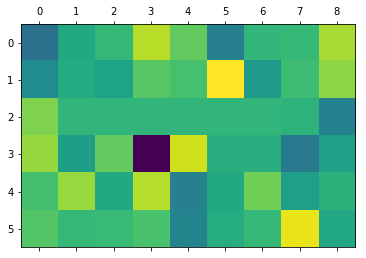

In [44]:
plt.matshow(df_coef[df_coef.index.str.contains('preffered_payment')])
df_coef[df_coef.index.str.contains('preffered_payment')]

By looking at the `preffered_payment` features, we see that payments with *credit_card* and *voucher* are more likely to be classified as **return**, while *debt_card* is complains about **other_order**. Customers that buys with *debt card* are not likely to complain that a product is **not as anounced*.

,before_estimate,delayed,low_quality,not_as_anounced,other_delivery,other_order,partial_delivery,return,satisfied
order_products_value,0.002305,0.011304,0.000471,0.069908,-0.023016,-0.004312,-0.024018,0.011546,-0.003607
order_freight_value,-0.001440,0.001054,0.000328,-0.004043,-0.001407,-0.000573,0.000192,0.000559,0.002758
review_score,-0.000102,-0.000497,-0.000384,-0.001105,-0.000166,-0.000107,-0.000268,-0.000443,0.001560
installments,-0.000131,0.000026,-0.000209,0.000311,-0.000377,-0.000125,0.000815,-0.000235,0.000286
value_std,-0.000122,-0.001400,0.001379,-0.003489,-0.000197,-0.000042,0.001003,-0.000524,-0.000332
review_answer,-0.000214,0.000147,0.000145,-0.003513,-0.000015,-0.000106,-0.001443,0.000198,0.000477
review_count,-0.000033,-0.000094,-0.000122,0.000253,-0.000120,-0.000022,0.000363,-0.000180,0.000113


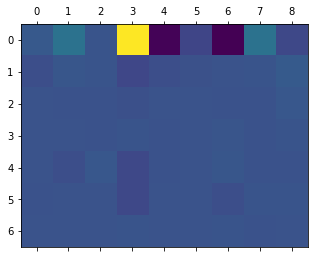

In [45]:
# df_coef[df_coef.index.str.contains('review_|installments|sequential|value')].transpose().boxplot(figsize=(8, 4), rot=20)
plt.matshow(df_coef[df_coef.index.str.contains('review_|installments|sequential|value')])
df_coef[df_coef.index.str.contains('review_|installments|sequential|value')]

The *review* features that are not the text itself and the other *payment* features are not a good indicators for the classifier. Besides that, we found that higher `products_value` correlates positively with **not as anounced** and negatively with **other_delivery** and **partial_delivery**.

,before_estimate,delayed,low_quality,not_as_anounced,other_delivery,other_order,partial_delivery,return,satisfied
populacao,-0.000426,-0.089821,0.300045,0.375883,0.873386,-0.065688,1.034204,-0.805319,-0.400065
area_km2,-0.395149,-1.143295,0.380096,0.373425,0.208313,-0.291811,1.928968,-0.158306,-0.461053
density,0.000145,0.000028,0.000062,-0.000043,-0.000118,-0.000020,-0.000251,0.000144,-0.000124


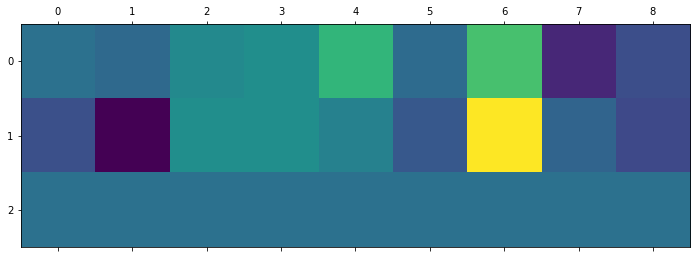

In [46]:
plt.matshow(df_coef[df_coef.index.str.contains('populacao|area_km2|density')])
df_coef[df_coef.index.str.contains('populacao|area_km2|density')]

The feature `populacao` is an indicator that the review is not from the **return** class, while `area_km2` is an indicator of **partial_delivery** and not an indicator of **delay**. The populational `density` does not helps classifying the data.

,before_estimate,delayed,low_quality,not_as_anounced,other_delivery,other_order,partial_delivery,return,satisfied
purchase_approved,0.000028,-0.000011,-0.000037,0.000059,-0.000104,-5.779725e-07,-7.294964e-08,0.000046,0.000003
purchase_delivered,-0.001626,0.006620,-0.000862,-0.001186,-0.001318,-4.949181e-04,-4.830368e-03,-0.000717,-0.000330
purchase_estimated,-0.001446,0.001073,-0.000443,-0.001569,-0.001601,-5.456646e-04,-1.093711e-04,-0.000221,0.002758
approved_estimated,-0.001477,0.001073,-0.000451,-0.001686,-0.001474,-5.401326e-04,-7.877365e-05,-0.000264,0.002782
approved_delivered,-0.001670,0.006625,-0.000845,-0.001306,-0.001232,-4.907428e-04,-4.820636e-03,-0.000737,-0.000293
estimated_delivered,-0.000161,0.005535,-0.000430,0.000425,0.000334,4.071537e-05,-4.699231e-03,-0.000518,-0.003111
review_answer,-0.000214,0.000147,0.000145,-0.003513,-0.000015,-1.060768e-04,-1.443077e-03,0.000198,0.000477
purchase_review,-0.001561,0.004822,-0.001031,-0.000139,-0.001574,-4.380828e-04,-3.088484e-03,-0.000526,0.000598


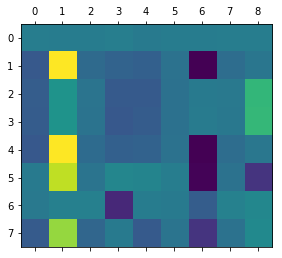

In [47]:
time_features_regex = 'purchase_approved|purchase_delivered|purchase_estimated|approved_estimated|approved_delivered|review_answer|purchase_review|estimated_delivered'
plt.matshow(df_coef[df_coef.index.str.contains(time_features_regex)])
df_coef[df_coef.index.str.contains(time_features_regex)]

Although we can see a correlation between the **delayed** feature and long *delivery time* (yellow squares), these features weights are low and are not good predictors of **delay**. This means that a purchase might have been delayed but the customer not necessarily complains about it.

,before_estimate,delayed,low_quality,not_as_anounced,other_delivery,other_order,partial_delivery,return,satisfied
mean_repeated_words,0.000073,-0.000102,0.000028,-0.000522,-0.000186,-0.000033,0.002043,-0.000431,-0.000646
mean_token_length,-0.000284,0.000086,0.000058,-0.000391,-0.000507,-0.000140,-0.000170,-0.000141,0.000708
mean_unique_tokens,-0.000087,0.000944,0.000763,0.002108,0.000419,-0.000145,0.000041,0.001157,-0.001224


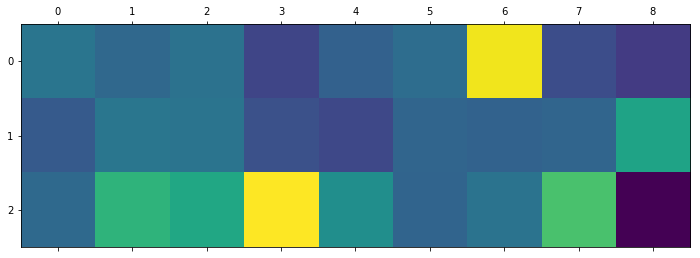

In [48]:
plt.matshow(df_coef[df_coef.index.str.contains('mean_unique_tokens|mean_token_length|mean_repeated_words')])
df_coef[df_coef.index.str.contains('mean_unique_tokens|mean_token_length|mean_repeated_words')]

For the textual features that we created, we see that the number of *unique words per review* is not a good indicator for **satisfied**, which makes sense because a customer is more likely to complain about a product than to complement. The fact that **not as anounced** has a positive weight in this feature further enforces this hypothesis.

One interesting point is that using many *repeated words* is an indicator of **partial_delivery**. Again these weights are not big so we can discard them.

,longo,correto,site,comprei,comprado,falta,faltou,apenas,frete,original,diferentes,correios,tipo,enviaram,errada,antes,cor,errado,foto,diferente
before_estimate,-0.531844,0.693350,0.977006,-0.287684,0.384910,-0.370675,-0.570772,-1.468863,-0.302474,-0.254635,-0.151785,-0.111824,-0.125085,-0.886503,-0.354076,17.120957,-0.464805,-0.989724,-0.183301,-0.714747
delayed,2.395100,-1.109109,1.868752,0.708163,-0.038686,-2.464342,-1.290190,-3.721714,-1.564184,-2.172315,-0.382048,-2.638575,-0.269809,-1.115156,0.249302,-3.194434,-0.894159,-0.645253,-1.378277,-1.254988
low_quality,-0.441721,-0.816493,0.732034,0.351645,0.658962,-1.073346,0.475299,-0.870822,-1.117678,4.626206,0.031973,-1.353445,-1.425400,-0.257318,0.660174,-1.229952,-1.460190,-0.383489,-0.112965,-1.102708
not_as_anounced,7.579037,9.605117,10.018404,10.144747,10.210354,-1.759662,-1.953419,-0.861013,-1.640920,13.000206,13.029049,-3.615375,14.455112,14.979812,16.106029,-4.720290,19.028831,20.844655,25.837643,26.195885
other_delivery,9.271780,-0.192453,-1.480316,-2.765754,-0.951080,0.520151,2.015161,-2.066803,12.592219,-1.523821,-0.204635,13.499945,0.543743,-0.226927,-0.313196,-0.680106,-0.354429,-0.305347,-1.642785,-1.953506
other_order,-0.448027,-0.140432,-0.220688,-1.000078,-0.077140,0.618534,-0.054329,-0.364452,-0.431692,-0.194248,-0.022281,0.155539,-0.046744,1.616968,-0.041330,-0.396205,-0.043193,-0.239820,-0.114588,-0.082686
partial_delivery,-0.963389,-0.189811,-2.603806,5.235015,-0.454151,10.270381,10.802888,11.567768,-1.113933,-0.742937,2.132036,-3.856777,-0.106718,-1.687921,-1.926908,-4.276458,-2.974580,-2.930919,-1.452986,-2.439870
return,-0.351881,-1.311961,-1.740047,0.498244,2.573625,2.180161,-3.821964,-1.794343,-0.184868,-2.309741,-1.210472,-1.816845,-0.097076,1.766252,4.214774,-1.166534,-0.018417,1.889760,-3.889205,-1.106455
satisfied,-4.072541,1.483004,-2.244564,-5.681542,-0.946678,-2.626406,-3.608470,-2.383890,-3.210186,-0.977236,-0.602147,-2.868730,-0.797912,-1.842540,-2.542122,-16.085683,-2.167031,-2.642233,-2.826040,-1.559512


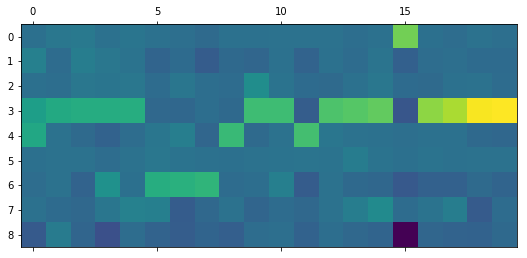

In [49]:
df_positive_words = df_coef.loc[df_coef.loc[words].max(axis=1).sort_values().tail(20).index].transpose()
plt.matshow(df_positive_words)
df_positive_words

The majority of hight weights belongs to **not as anounced**, this can be explained by the fact that the dataset is not well balanced and we did not treated that, so these words try to compensate the few datapoints. Besides that, some words makes perfect sense to be assigned to this class, words like *foto, diferente, errado* are a good indicator of a disapointment.

From the words that we've got, we see that words like *falta, faltou, apenas* are associated with **partial delivery**. 

,antes,corretamente,04,qualidade,defeito,solicitei,celular,bom,cortinas,junto,prazo,fiscal,chegou,ja,nao,ainda,jogo,comprei,lojas,veio
before_estimate,17.120957,0.930408,2.255021,-0.225030,-0.302766,-0.125212,-0.367916,-0.451690,-0.203045,-0.077121,2.145780,-0.356590,3.790131,-1.621026,-2.724716,0.709604,-0.200130,-0.287684,0.946557,1.394733
delayed,-3.194434,-0.259480,-0.584328,-2.387207,-1.039892,-1.642858,0.174315,-2.807061,-1.382892,0.440222,-1.172145,-0.321633,0.687545,2.355746,5.327757,3.695831,-1.359658,0.708163,0.249910,-2.912494
low_quality,-1.229952,0.363633,-0.538692,4.324823,-0.501319,-0.544137,3.218257,-1.212040,-0.616296,-1.408782,-2.134539,1.038956,-1.628758,0.889797,2.532728,-2.519703,-1.334662,0.351645,-0.568606,1.145080
not_as_anounced,-4.720290,-8.808723,-8.658685,-8.634833,-8.496750,-8.063524,-7.415858,-6.689343,-6.654314,-6.627537,-6.595561,-6.583894,-6.522694,-6.489153,7.304820,-6.167642,-5.862794,10.144747,-5.581577,6.348632
other_delivery,-0.680106,0.171322,2.506044,-2.888807,-0.641788,-0.250559,-0.045578,-1.803038,-0.065806,-1.396954,0.102324,-2.595782,-0.967242,-0.138422,2.883136,-4.573453,-0.300670,-2.765754,-0.854488,0.418743
other_order,-0.396205,-0.040548,-0.029176,-0.436661,-0.050071,-0.016983,-0.093532,-0.903653,-0.027556,0.797330,0.031618,1.525282,-1.913338,0.413613,2.154133,-0.587344,-0.013243,-1.000078,-0.088343,-0.687779
partial_delivery,-4.276458,-0.610730,-0.874321,-2.725718,-0.711724,-0.826983,-1.228267,-3.434011,4.933431,5.729249,-5.237037,4.172200,7.116658,1.197791,-0.809355,-0.160884,4.047185,5.235015,0.452426,1.424268
return,-1.166534,1.155213,3.866696,3.180449,7.859143,8.970632,1.117881,-3.607808,-0.481477,-1.141344,-1.751733,1.968794,-0.686191,2.993152,1.094804,0.128087,0.922554,0.498244,1.149875,7.011934
satisfied,-16.085683,-0.273455,-1.696953,-0.729518,-1.594722,-0.246986,-1.139632,3.485260,-1.327034,-0.370331,2.097291,-0.556368,-2.831341,-2.364208,-6.242540,-1.009233,-0.215812,-5.681542,0.859398,-5.429695


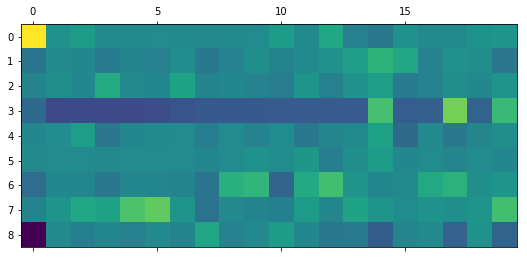

In [50]:
df_negative_words = df_coef.loc[df_coef.loc[words].min(axis=1).sort_values().head(20).index].transpose()
plt.matshow(df_negative_words)
df_negative_words

From the most negative words, we found once again the high bias towards **not as anounced**, but this time the weights tries to diferentiate this class from the others, for example, the words *qualidade* and *defeito* are more prone to be **return** than **not as anounced**.

### 6. Final Model

With the acquired knowledge, we will train a new model and see if we can improve the performance.

In [51]:
# Creating training and test sets
labels = [
    'votes_before_estimate',
    'votes_delayed',
    'votes_low_quality',
    'votes_return',
    'votes_not_as_anounced',
    'votes_partial_delivery',
    'votes_other_delivery',
    'votes_other_order',
    'votes_satisfied'
]
keep_features = [
    'order_status', 
    'customer_state',
    'product_category_name',
    'preffered_payment',
    'populacao',
    'area',
]

features = df_feat.columns[df_feat.columns.str.contains("|".join(keep_features))].append(pd.Index(words))
Y = df_feat[labels]
X = df_feat[features]

y, weights = zip(*Y.apply(calculate_label, axis=1, args=(Y.sum(),)))

X_train, X_test, y_train, y_test, w_train, w_test = model_selection.train_test_split(X, y, weights, random_state=42)

In [52]:
model2 = linear_model.LogisticRegressionCV(Cs=[0.7, 0.9, 1.0, 1.1, 1.3])
model2.fit(X_train, y_train, w_train)

LogisticRegressionCV(Cs=[0.7, 0.9, 1.0, 1.1, 1.3], class_weight=None, cv=None,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

Model Accuracy Train: 88.1 %
Model Accuracy Test: 77.1 %
Confusion matrix:


,before_estimate,delayed,low_quality,return,not_as_anounced,partial_delivery,other_delivery,other_order,satisfied
before_estimate,77,3,2,0,0,0,1,0,22
delayed,0,70,0,0,1,0,4,0,14
low_quality,1,5,7,1,0,0,2,4,13
return,0,5,4,22,0,0,3,3,10
not_as_anounced,1,0,1,0,4,0,0,1,5
partial_delivery,0,3,0,0,0,0,1,0,1
other_delivery,0,7,0,0,2,0,59,1,1
other_order,1,6,0,2,0,0,2,5,6
satisfied,15,3,2,1,0,0,1,0,298


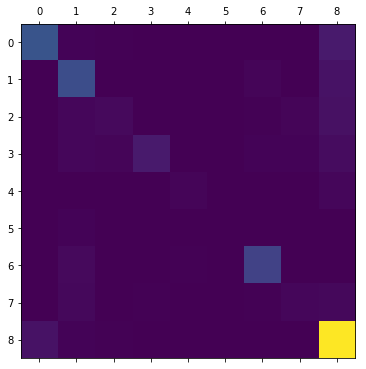

In [53]:
print("Model Accuracy Train:", (model2.score(X_train, y_train)*100).round(1), "%")
print("Model Accuracy Test:", (model2.score(X_test, y_test)*100).round(1), "%")
print("Confusion matrix:")
confusion = metrics.confusion_matrix(y_test, model2.predict(X_test))
plt.figure(figsize=(6,6))
plt.matshow(confusion, fignum=1)
pd.DataFrame(confusion, columns=labels2, index=labels2)

Our final model is marginaly better than the first one, and also is not as overfitted. We reduced the dimensionality of the model, making it easier to explain and without losing accuracy.

We found some interesting insights from the data but we did not investigated further.

There is still lots to study in this dataset and lots of cogs to tweak in these models, but one thing that surely would improve it's performance would be more classified data.